In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/PhC-C2DH-U373.zip

In [1]:
! git clone https://github.com/GullinoAgus/TP02-RN

Cloning into 'TP02-RN'...
remote: Enumerating objects: 790, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 790 (delta 27), reused 40 (delta 19), pack-reused 742
Receiving objects: 100% (790/790), 42.51 MiB | 21.10 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [1]:
!pip install tensorflow_addons


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Nadam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
from PIL import Image

# $\textit{Cargamos Train y Val}$

Nota: Train será aumentado.

In [3]:
train_path = Path("./TP02-RN/PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("./TP02-RN/PhC-C2DH-U373/02/").glob("**/*tif")


In [4]:
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'./TP02-RN/PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'./TP02-RN/PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

In [5]:
train_images = np.vstack(train_images)/255
train_masks = 1*(np.vstack(train_masks) > 0)
val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) >0 )

En este codigo de arriba se separan las imagenes para train y validacion junto con sus mascaras. 115 para entrenar y 115 para validar.

# $\textit{Imágenes de train sin aumentar}$

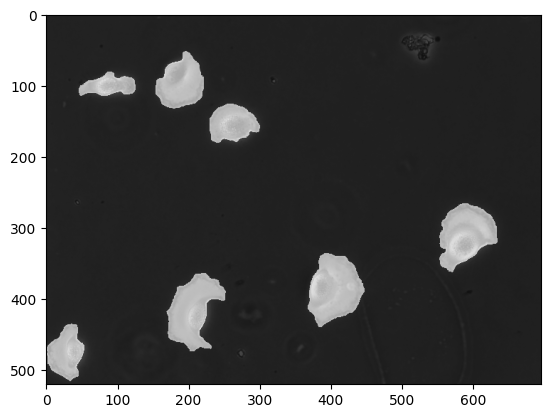

In [6]:
idx = 100
plt.imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")
plt.imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.6)
plt.show()

# $\textit{Armamos datasets y aumentamos los datos}$

Para mantener sincronizada la data aumentation entre la imagen y la máscara, armamos una entrada de 4 canales que se descompondrán durante el entrenamiento.

In [7]:
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)

In [8]:
x_train[0,:,:,0].max()

0.7254901960784313

In [9]:
x_val.shape

(115, 520, 696, 2)

In [10]:
len(x_train)

115

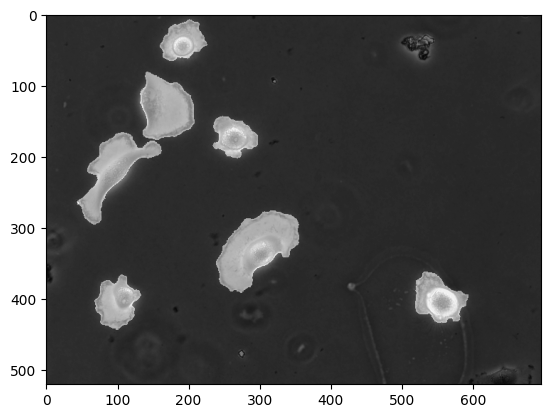

In [11]:
plt.imshow(x_train[0,:,:,0], cmap="gray")
plt.imshow(x_train[0,:,:,1], cmap="gray", alpha = 0.5)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

# $\textit{Armamos un modelo base con Atrous Convolutions}$

In [13]:
filters = 16
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])


La red Falopa:
Basicamente es una cadena de convolucionales cuyo dilation_rate subimos en potencias de 2. Esto genera un incremento del FOV de cada capa equivalente a un kernel de tamaño DR $\times$ (N-1) + 1, siendo N el kernel_size. Para un DR=4 implica el mismo FOV es el equivalente a un kernel de 37x37 en el caso de un kernel inicial de 10x10. Este aumento del tamaño del kernel mantiene la cantidad de parametros, ya que es analogo a agregar 0 en las celdas del kernel expandido, por lo que se incrementa el FOV sin aumentar la cantidad de parametros. Esto mantiene el tiempo de computo bajo aumentando el FOV.

Basicamente este modelo toma la imagen y analiza features en un FOV creciente pero con poco detalle (usa pocos parametros) y espera lograr diferenciar celulas de esta manera. En la anteultima capa se utiliza una convolucional con dilation_rate=1 para converger los filtros anteriores a filtros mas complejos, combinando todas los canales del feature map. Por ultimo, la ultima capa genera un unico filtro que sera la mascara la cual contendra en cada pixel la probabilidad que pertenezca a la celula.


![picture](https://miro.medium.com/v2/resize:fit:640/1*SVkgHoFoiMZkjy54zM_SUw.gif)

![picture](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*ssV3Bqv-9JxhuuYuVsZogA.png)

# $\textit{Armamos la red de preprocesamiento}$

In [14]:
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

Estas funciones de preprocesamiento corresponden al data augmentation utilizado, con cropeos y flipeos aleatorios, todo esto para train. En validacion solo se realiza un cropeo a 512x512.

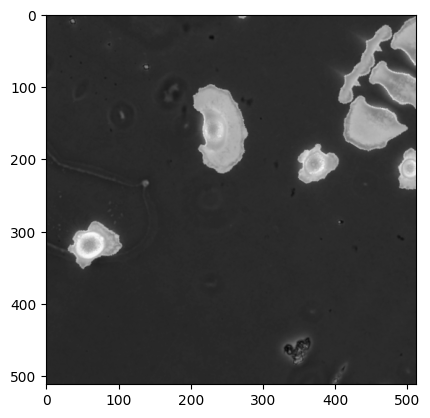

In [15]:
preproc = get_preproc()
aux_elem = preproc(x_train[0])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

In [16]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

La funcion dice_coef calcula el coeficiente dice. Las primeras dos lineas generan un vector 1D a partir de las mascaras, las cuales seran usadas para medir en nivel de coincidencia realizando la suma del producto entre la mascara real y la mascara que devuelve el modelo. Con esto se obtiene un vector con 0s y distintas probabilidades de aparicion de celulas en esas posiciones, y luego se evalua el coef_dice de acuerdo a la formula siguiente:

![picture](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)

In [17]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = True

    def call(self, inputs):
        #img_mask = self.red_preproc = red_preproc(inputs)
        return self.red_segmentacion(inputs[:,:,:1])

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            data_aug = self.red_preproc(data)
            loss = self._compute_loss(data_aug)
            #print(K.mean(loss))

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        #aux = self.red_preproc(data)
        mask_out = self.red_segmentacion(data[:,:,:,:1])
        #print(mask_out.shape)
        #print(data[:,:,:,1:2].numpy())
        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out)
        return loss

    # property
    # def metrics(self):
    #     # We need to list our metrics here so the `reset_states()` can be
    #     # called automatically.
    #     return [self.loss_tracker]

Este codigo define una subclase de Model de Keras que tiene implementada la posibilidad de usar preprocesamiento (Data augmentation) en el entrenamiento y en el test. Para el caso del test, se realiza un recorte centrado en el centro de la imagen de 512x512 (No de forma aleatoria como en train). Ademas, se puede elegir entre dos loss diferentes, ya sea la dice loss o la binary crossentropy. Por otro lado, implementa manualmente el entrenamiento de descenso por gradiente.

In [18]:
red_falopa = get_red_seg()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

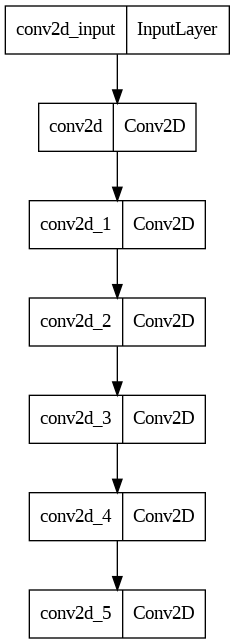

In [ ]:
red_falopa.summary()
plot_model(red_falopa)

In [ ]:
preproc= get_preproc()
preproc_val = get_preproc_val()
red_falopa = get_red_seg()
model = SegmentationModel(preproc, red_falopa,preproc_val)

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [ ]:
len(x_val)

115

Instanciamos un modelo de para entrenarlo y probarlo.

In [ ]:
model.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 76s 2s/step - loss: 0.6787 - val_loss: 0.6145
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 0.5296 - val_loss: 0.2596
Epoch 3/100
8/8 [==============================] - 8s 1s/step - loss: 0.3603 - val_loss: 0.1718
Epoch 4/100
8/8 [==============================] - 8s 1s/step - loss: 0.3488 - val_loss: 0.2377
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 0.3366 - val_loss: 0.1901
Epoch 6/100
8/8 [==============================] - 8s 1s/step - loss: 0.3337 - val_loss: 0.1969
Epoch 7/100
8/8 [==============================] - 8s 1s/step - loss: 0.3253 - val_loss: 0.1902
Epoch 8/100
8/8 [==============================] - 9s 1s/step - loss: 0.3218 - val_loss: 0.1913
Epoch 9/100
8/8 [==============================] - 8s 1s/step - loss: 0.3189 - val_loss: 0.1877
Epoch 10/100
8/8 [==============================] - 8s 1s/step - loss: 0.3163 - val_loss: 0.1886
Epoch 11/100
8/8 [====================

In [ ]:
pred = red_falopa(x_val[0:1,:,:,0])
pred.shape

TensorShape([1, 520, 696, 1])

In [ ]:
pred.numpy().max()

0.99586076

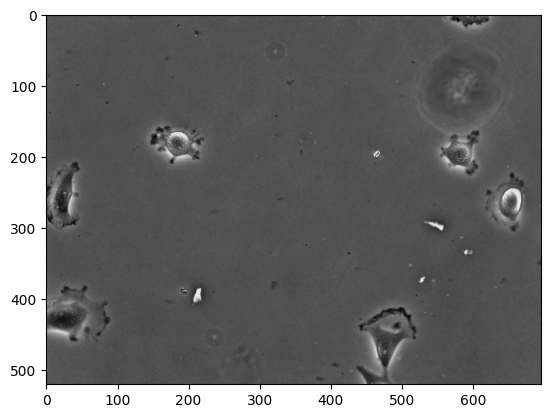

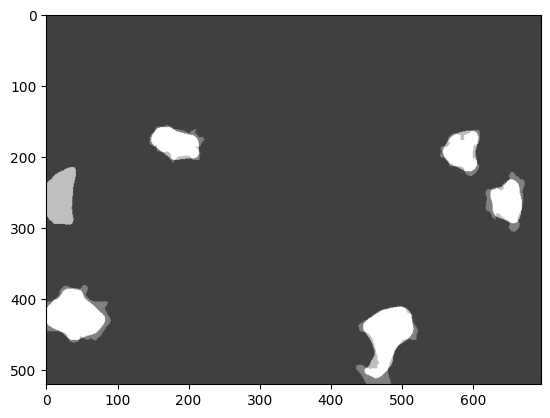

In [ ]:
plt.imshow(x_val[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

Despues de los 100 epochs se observan los resultados, y se ve que funciona bastante bien. No es optimo ya que perdio de vista una celula a la izquierda, pero esta bastante bien.

# $\textit{UNet}$

In [19]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose

In [20]:
img_shape = (512, 512, 1)
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

En el bloque de arriba hay 3 funciones importantes:
### conv_block
Esta funcion se encarga de generar los bloques de capas convolucionales que van entre cada cambio de nivel en la UNet. despues de cada capa de conv_transpose se encuentran estos bloques de filtros convolucionales, y antes de cada maxpooling para descender en profundidad hay un bloque convolucional.

En particular es un bloque simple de 2 capas de convolucion con BatchNorm y Dropout configurables, y cada capa tiene filtros de tamaño 3 y una cantidad variable. Tambien se puede modificar la funcion de activacion y si se quiere agregar a la salida la entrada al bloque (Skip connections, pero solo para este bloque)

### level_block

Esta es la funcion que termina construyendo la U. Toma los bloques convolucionales de la funcion anterior y agrega Maxpooling o Transpose en caso de que se este descendiendo o ascendiendo en profundidad, respectivamente. Permite definir si se quiere utilizar upsampling en vez de transpose.

### UNet

Termina de crear el modelo y recibe los parametros que este requiera.

### UpSampling vs Transpose convolution

El Upsampling es una tecnica conocida que copia los valores de 1 pixel y los coloca en un espacio mayor. Por ejemplo, un UpSampling de 3x3 toma un pixel y lo repite 9 veces (en un cuadrado de 3x3) aumentando el tamaño de la imagen. El valor default de UpSampling es 2x2.

En el caso del Transpose, este toma un pixel de la imagen y genera NxN pixeles (segun el tamaño del kernel) para la salida. Estos NxN parametros son entrenables, y esta es la principal diferencia con el UpSampling. Este metodo se reduce a UpSampling si todos los parametros entrenables se convierten en 1. Tambien hay que tener en cuenta la posiblidad de agregar stride, entre otras cosas.

Se puede ver que ambos permiten aumentar las dimensiones de la entrada, solo que uno tiene mas grados de libertad, lo que aumenta el espacio de soluciones posibles.

In [21]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = 0.1,
    depth = 5,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [23]:
BATCH_SIZE = 8


callbackROP = ReduceLROnPlateau(monitor="loss",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 10,)
callbackES = EarlyStopping(monitor='val_loss', patience=20)

In [24]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4), metrics=[dice_coef])

In [ ]:
model_unet.fit(np.vstack([x_train, x_val]),batch_size=BATCH_SIZE, epochs=100, validation_split = 0.5, verbose = 1, callbacks=[callbackES, callbackROP])

Epoch 1/100
15/15 [==============================] - 61s 2s/step - loss: 0.8481 - val_loss: 0.9312 - lr: 1.0000e-04
Epoch 2/100
15/15 [==============================] - 16s 1s/step - loss: 0.8413 - val_loss: 0.9272 - lr: 1.0000e-04
Epoch 3/100
15/15 [==============================] - 14s 932ms/step - loss: 0.8200 - val_loss: 0.9037 - lr: 1.0000e-04
Epoch 4/100
15/15 [==============================] - 14s 928ms/step - loss: 0.7766 - val_loss: 0.8760 - lr: 1.0000e-04
Epoch 5/100
15/15 [==============================] - 14s 932ms/step - loss: 0.8458 - val_loss: 0.9951 - lr: 1.0000e-04
Epoch 6/100
15/15 [==============================] - 14s 923ms/step - loss: 0.9970 - val_loss: 0.9889 - lr: 1.0000e-04
Epoch 7/100
15/15 [==============================] - 14s 933ms/step - loss: 0.9861 - val_loss: 0.9286 - lr: 1.0000e-04
Epoch 8/100
15/15 [==============================] - 16s 1s/step - loss: 0.8491 - val_loss: 0.9312 - lr: 1.0000e-04
Epoch 9/100
15/15 [==============================] - 16s 

In [ ]:
def dice_coef_2(y_true, y_pred, smooth=1e-6):
    y_true_f = np.ravel(y_true)
    y_pred_f = np.ravel(y_pred)
    intersection = np.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)
    return dice

inputs = x_val[0:1,:,:,0]
pred = red_unet(inputs)

dc = dice_coef_2(inputs, pred)
print(dc)

Log de entrenamiento:
* Solo con cyclical LR y usando DICE de Loss: val_loss_minima: 0.2295 - dice_coef: 0.7705
Se ve bastante estancado el modelo una vez alcanza el epoch 50. No overfittea. Creo que hay q aumentar la profundidad de la red

* Depth de 6: No funciono, revienta colab.

* Depth de 5: Parece arrojar mejores resultados de Dice que con 4 capas. pero overfittea un poco.

* Depth de 5 0.1 dropout: Mejoro el overfiting, me gusta como quedo


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 512, 512, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_33[0][0]']              
                                )                                                           

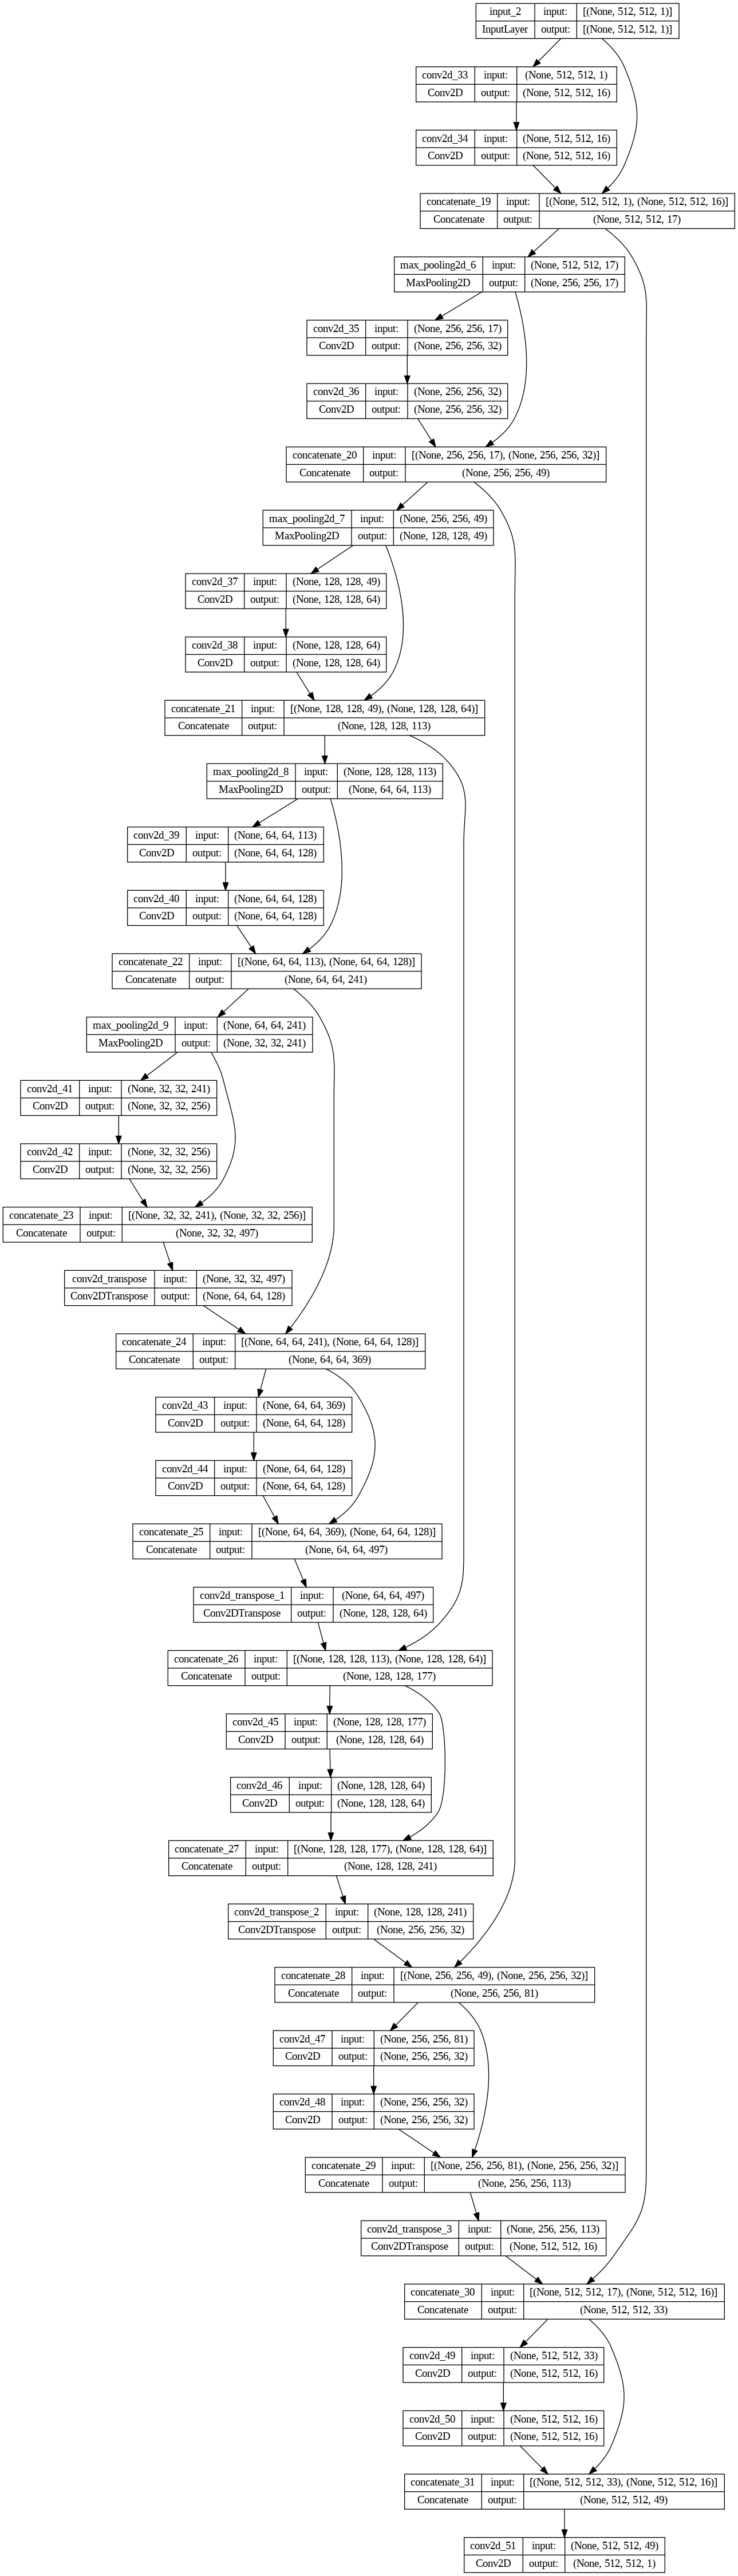

In [31]:
red_unet.summary()
plot_model(red_unet, show_shapes=True)

En la imagen se puede ver bien el modelo resultante con las conexiones entre bajada y subida, ademas de la UNet.

In [ ]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

In [ ]:
pred.numpy().max()

0.99984324

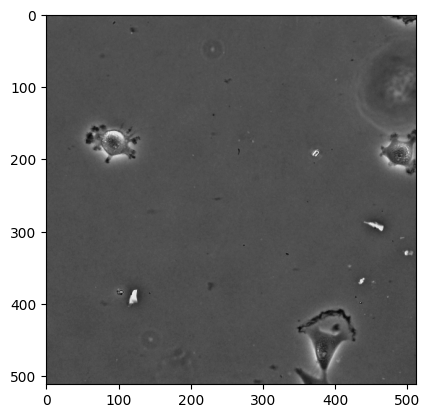

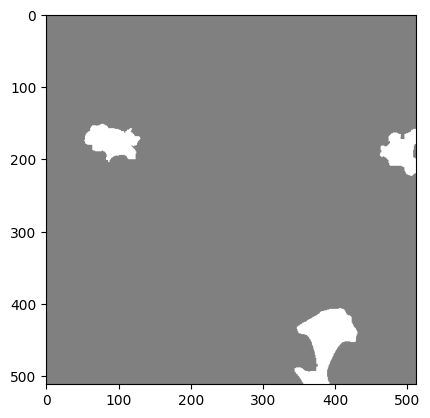

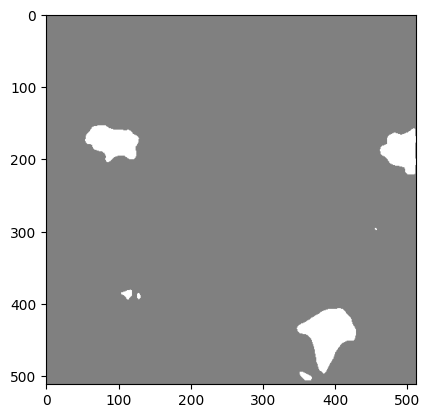

In [ ]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()

Se puede ver que los resultados son bastante buenos y se detectaron todas las celulas. El unico problema observable es la aparicion de falsos positivos donde se ve que la imagen original tiene algunos elementos desconocidos pero no estan catalogados como celulas.